# EAA Winter School in Computational Acoustics 2018

## Finite-difference tutorial

### Preamble

We begin by loading a number of standard modules such as `numpy` and `matplotlib`. We also adjust some default parameters of figures.

In [1]:
import numpy as np
from numpy import exp, sqrt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
mpl.rc('lines', linewidth=2)
mpl.rc('font', size=14)
mpl.rc('axes', linewidth=1.5, labelsize=14)
mpl.rc('legend', fontsize=14)

### Definition of the problem

We consider the problem of the transport equation (also known as the one-way wave equation)
$$
\frac{\partial f}{\partial t}
+ a \frac{\partial f}{\partial x}
= 0
\;,
$$
where $f(x,t)$ is the solution of the problem and $a$ is the constant convection veclocity.
This equation is solved on the domain $0<x<L$ between the initial time $t=T_\mathrm{min}$ and the final time $t=T_\mathrm{max}$.

The initial condition is of the form:
$$
f(x,t=0) = \exp[-(x-x_0)^2/w^2]
\;,
$$
where $x_0$ is the initial position of the waveform and $w$ is the width of the waveform.

We use periodic boundary conditions between the two end points of the computational domain. In other word: $f(x=0,t)=f(x=L,t)$.

We define the physical parameters introduced so far:

In [2]:
a = 1  # Convection velocity
w = 1  # Width of the waveform
L = 20  # Length of the domain
x0 = L/2 # Initial position of the waveform
Tmin = 0  # Initial time
Tmax = 40  # Final time

We also define a function implementing the exact solution to this problem:

In [3]:
def f_exact(x, t):
    s = np.mod(x-t, L)-x0
    return(s*np.exp(-s**2/w**2/2))

### Numerical schemes

We use the standard 5-point, centered finite-difference scheme for the spatial derivative. Its coefficients are:
$$
a_{-2} = -\frac{1}{12}
\;,\quad
a_{-1} = \frac{2}{3}
\;,\quad
a_{0} = 0
\;,\quad
a_{+1} = -\frac{2}{3}
\;,\quad
a_{+2} = \frac{1}{12}
\;.
$$
This is define as follows:

In [4]:
FD5 = np.array([-1/12, 2/3, 0, -2/3, 1/12])

**Question:** What is the order of this scheme?

For the time integration we use the standard 4-stage Runge--Kutta scheme. Its coefficient are defined as follows:

In [5]:
RK4 = np.array([0.25, 1./3., 0.5, 1.])

**Question:** What is the order of this scheme?

### Grid

We use a uniform grid with $N$ points:

In [6]:
N = 100

We define the grid points $x_n$ and the grid spacing $\mathrm{d}x$:

In [7]:
xn = np.linspace(0, L, N)
dx = xn[1] - xn[0]

We have to extend the grid to include additional points for the periodic boundary condition.

In [8]:
xn = np.linspace(-2*dx, L+1*dx, N+3)

### Time step

The time step is defined through the CFL number $a\Delta t/\Delta x$

In [9]:
CFL = 1.5

We calculate the time step from this value of the CFL number.
We can then calculate the number of time steps $N_t$ to reach $t=T_{max}$.

In [10]:
dt = dx*CFL/a
Nt = int(np.ceil((Tmax-Tmin)/dt)+1)
tn = np.linspace(Tmin, Tmax, Nt)
dt = tn[1] - tn[0]

### Simulation

We can now perform the numerical simulation of the solution.

We define a vector containing the initial condition:

In [11]:
f0 = np.transpose(f_exact(xn, Tmin)).reshape(len(xn),)

We can then perform the time integration

In [12]:
f = f0.copy()
t = Tmin

F = np.zeros((Nt, len(f)))
T = np.zeros((Nt, ))

# Loop over the time step
for step in range(Nt):
    # Store the current solution and time step
    F[step, :] = f
    T[step] = t
    fn = f.copy()
    for stage in range(len(RK4)):
        # Calculate the spatial derivative of the solution
        dfdx = np.convolve(f, FD5, 'same')/dx
        # Calculate the time derivative of the solution
        dfdt = -a*dfdx
        # Update the solution using the Runge-Kutta time marching scheme
        f = fn + RK4[stage]*dt*dfdt
        # Implement the periodic boundary condition
        f[:2] = f[-4:-2].copy()
        f[-2:] = f[2:4].copy()
    t += dt

### Visualisation

We can generate an animation of the solution as follows:

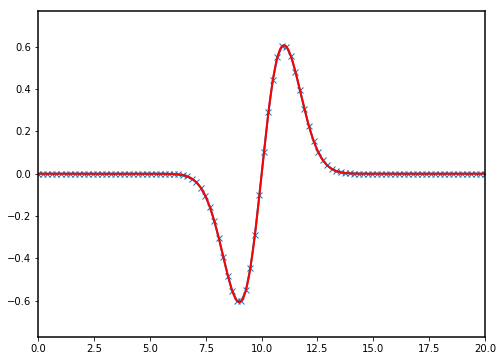

In [13]:
fig = plt.figure(figsize=(8,6));
ax = plt.gca()
l, = ax.plot([0,L],[-0.7,0.7], '-x');
l2, = ax.plot([0,L],[-0.7,0.7], 'r-');
plt.xlim(0, L)

xx = np.linspace(0, L, 1000)

def animate(i):
    l.set_data(xn, F[i,:]);
    l2.set_data(xx, f_exact(xx, T[i]));

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt);
ani